In [156]:
# Ensure the project root is in the Python path
import sys
sys.path.append('/Users/tl759k/Documents/GitHub/work/cursor-analytics')

# Activate the virtual environment (if not already activated)
# This is typically done outside the notebook, but we ensure the path is correct here
import os
os.system('source /Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/bin/activate')

# Re-import the SnowflakeHook after ensuring the path is set
from utils.snowflake_connection import SnowflakeHook


In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.graph_objects as go
import seaborn as sns

In [144]:
# Load the SQL query from the file
def load_query(file_path):
    with open(file_path, 'r') as file:
        query = file.read()
    snowhook = SnowflakeHook()
    df = snowhook.query_snowflake(query, method='pandas')

    # format decimal to float
    for col in df.columns:
        if df[col].dtype == 'object' and isinstance(df[col].dropna().iloc[0], Decimal):
            df[col] = df[col].astype(float)

    return df

In [352]:
daco_spend_to_applicants_curve = load_query('daco_spend_to_applicants.sql')
new_dx_landing_curve = load_query('apps_to_new_dx_landing_curve.sql')
new_dx_retention_curve = load_query('new_dx_retention.sql')
global_dx_retention = load_query('global_dx_retention.sql')

2025-08-20 13:02:00,181 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-20 13:02:00,182 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-20 13:02:00,641 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-20 13:02:00,642 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-20 13:02:02,986 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-20 13:02:02,987 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-20 13:02:03,287 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-20 13:02:03,288 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-20 13:02:03,832 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-20 13:02:03,833 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-20 13:02:04,138 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-20 13:02:04,138 - utils.snowflake_connection - INFO - Executing query (pandas)
2025-08-20 13:02:27,802 - utils.snowflake_connection - ERROR - Failed to create optimized Spark session: Java gateway process exited before sending its port number
2025-08-20 13:02:27,803 - utils.snowflake_connection - ERROR - Failed to create Spark session: Java gateway process exited before sending its port number


The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

/Users/tl759k/Documents/GitHub/work/cursor-analytics/venv/lib/python3.11/site-packages/pyspark/bin/spark-class: line 96: CMD: bad array subscript
head: illegal line count -- -1


2025-08-20 13:02:28,515 - utils.snowflake_connection - INFO - Successfully connected to Snowflake
2025-08-20 13:02:28,516 - utils.snowflake_connection - INFO - Executing query (pandas)


In [589]:
# aggregate daco spend to applicants curve
def spend_to_apps(daco_spend_to_applicants_curve, submarket_id):

    df = daco_spend_to_applicants_curve.copy()
    df = df[df['submarket_id'] == submarket_id].reset_index(drop = True)
    df_agg = df.groupby(['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id']).agg({'spending': 'mean', 'applicants': 'sum', 'new_dx': 'sum'}).reset_index(drop = False)
    df_agg['cost_per_new_dx'] = df_agg['spending'] / df_agg['new_dx']
    df_agg['horizon_spend'] = 0 # assign horizon 0 to all rows

    # check mCPD
    df_agg = df_agg.sort_values(by=['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id'])
    df_agg['spending_diff'] = df_agg['spending'].diff()
    df_agg['new_dx_diff'] = df_agg['new_dx'].diff()

    # Calculate marginal cost per new dx
    df_agg['marginal_cost_per_new_dx'] = df_agg['spending_diff'] / df_agg['new_dx_diff']

    df_agg['new_dx_ratio_daco'] =  df_agg['new_dx'] / df_agg['applicants']

    df_agg = df_agg[['forecast_quarter', 'forecast_week','mcpd_scenario','submarket_id','spending','applicants','new_dx','cost_per_new_dx','marginal_cost_per_new_dx','new_dx_ratio_daco','horizon_spend']].reset_index(drop = True)

    return df_agg

# new dx landing curve
def apps_to_new_dx(new_dx_landing_curve, df_spend_to_apps):
    df_new_dx = new_dx_landing_curve.merge(df_spend_to_apps, how='cross')
    df_new_dx['new_dx_conv'] = df_new_dx['new_dx_cvr'] * df_new_dx['applicants']
    return df_new_dx


def new_dx_52w(df_new_dx):
    df_new_dx_52w = df_new_dx.groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'new_dx_conv': 'sum'}).reset_index(drop = False)
    df_new_dx_52w.rename(columns={'new_dx_conv': 'new_dx_conv_52w'}, inplace=True)
    df_new_dx_26w = df_new_dx[df_new_dx['horizon_conv'] <= 26].groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'new_dx_conv': 'sum'}).reset_index(drop = False)
    df_new_dx_26w.rename(columns={'new_dx_conv': 'new_dx_conv_26w'}, inplace=True)

    df_new_dx_52w = df_new_dx_52w.merge(df_new_dx_26w, how='left', on=['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx'])
    df_new_dx_52w['new_dx_ratio_52w'] = df_new_dx_52w['new_dx_conv_52w'] / df_new_dx_52w['applicants']
    
    return df_new_dx_52w

def new_dx_to_cpih(df_new_dx, new_dx_retention_curve, global_dx_retention):
    
    new_dx_retention_curve['horizon_ret'] = new_dx_retention_curve['tenure'].astype(int)
    global_dx_retention['horizon_ret'] = global_dx_retention['tenure'].astype(int)

    new_dx_retention_curve['tot_hours'] = new_dx_retention_curve['tot_baseline_dx'] * new_dx_retention_curve['online_hours']
    new_dx_retention_curve['hours_per_active_dx'] = new_dx_retention_curve['tot_hours'] / new_dx_retention_curve['tot_active_dx']

    new_dx_retention_curve = new_dx_retention_curve.merge(global_dx_retention, how='left', on='horizon_ret')

    new_dx_retention_curve = new_dx_retention_curve[['horizon_ret','cum_sum_hr','pct_retained','online_hours','hours_per_active_dx','dx_retention']] 

    df_new_dx_ret = new_dx_retention_curve.merge(df_new_dx, how='cross')

    df_new_dx_ret['new_dx_retained'] = df_new_dx_ret['new_dx_conv'] * df_new_dx_ret['pct_retained']
    df_new_dx_ret['online_hours_retained'] = df_new_dx_ret['new_dx_retained'] * df_new_dx_ret['hours_per_active_dx']

    df_new_dx_ret['week'] = df_new_dx_ret['horizon_ret'] + df_new_dx_ret['horizon_conv']
    df_new_dx_ret['week'] = df_new_dx_ret['week'].astype(int)
    
    return df_new_dx_ret

In [590]:
def plot_mcpd_and_cpih(title,df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4):
    # Create the plot
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='mcpd_scenario', y='cpih_adj', marker='o', label='26 Weeks', linewidth=2.5)
    sns.lineplot(data=df_cpih_wad_52w_agg_q4, x='mcpd_scenario', y='cpih_adj', marker='o', label='52 Weeks', linewidth=2.5)
    sns.lineplot(data=df_cpih_wad_26w_agg_q4, x='mcpd_scenario', y='cpih_adj_lifetime', marker='o', label='Lifetime', linewidth=2.5)
    # Customize the plot
    plt.title(f'{title}', fontsize=12, fontweight='bold')
    plt.xlabel('MCPD Scenario', fontsize=8)
    plt.ylabel('CPIH Adjusted', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=8)
    # Show the plot
    plt.show()

In [591]:
def cost_curve(df_new_dx_ret, horizon, new_dx_retention_curve, df_new_dx_52w):

    new_dx_retention_curve['horizon_ret'] = new_dx_retention_curve['tenure'].astype(int)
    lifetime_hours_per_dx_52w = new_dx_retention_curve[new_dx_retention_curve['horizon_ret'] == 52]['cum_sum_hr'].values[0]

    df_agg = df_new_dx_ret[df_new_dx_ret['week'] <= horizon].reset_index(drop = True)

    df_agg = df_agg.groupby(['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx']).agg({'online_hours_retained': 'sum', 'new_dx_retained': 'sum'}).reset_index(drop = False)

    df_agg = df_agg.merge(df_new_dx_52w, how='left', on=['forecast_quarter','forecast_week', 'mcpd_scenario', 'submarket_id','spending', 'applicants', 'new_dx'])
    df_agg['lifetime_hours'] = df_agg['new_dx_conv_52w'] * lifetime_hours_per_dx_52w

    df_agg['cpih'] = df_agg['spending'] / df_agg['online_hours_retained']
    df_agg['cpih_lifetime'] = df_agg['spending'] / df_agg['lifetime_hours']
    df_agg['cpih_adj'] = df_agg['cpih'] * 13 / 11  # adjust for online hours -> contribution hours (13 online hours -> 11 contribution hours)
    df_agg['cpih_adj_lifetime'] = df_agg['cpih_lifetime'] * 13 / 11 # adjust for online hours -> contribution hours (13 online hours -> 11 contribution hours)

    df_agg = df_agg[['forecast_quarter','forecast_week','mcpd_scenario','submarket_id','spending','cpih','cpih_lifetime','cpih_adj','cpih_adj_lifetime']].reset_index(drop = True)


    return df_agg

In [485]:

# df_new_dx_ret[(df_new_dx_ret['mcpd_scenario'] == 1000) & (df_new_dx_ret['forecast_week'] == '2025-10-06') & (df_new_dx_ret['horizon_conv'] == 0)]

In [592]:
def run_analysis(sm_list, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention):

    df_spend_to_apps = spend_to_apps(daco_spend_to_applicants_curve, sm_list) # daco spend to applicants curve
    df_new_dx = apps_to_new_dx(new_dx_landing_curve, df_spend_to_apps) # new dx conv by horzion
    df_new_dx_52w = new_dx_52w(df_new_dx) # new dx total over 52 weeks
    df_new_dx_ret = new_dx_to_cpih(df_new_dx, new_dx_retention_curve, global_dx_retention)
    df_cpih_wad_26w = cost_curve(df_new_dx_ret, 26, new_dx_retention_curve, df_new_dx_52w)
    df_cpih_wad_52w = cost_curve(df_new_dx_ret, 52, new_dx_retention_curve, df_new_dx_52w)

    df_cpih_wad_26w_agg = df_cpih_wad_26w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'cpih_adj': 'mean','cpih_adj_lifetime': 'mean'}).reset_index(drop = False)
    df_cpih_wad_52w_agg = df_cpih_wad_52w.groupby(['forecast_quarter', 'mcpd_scenario', 'submarket_id']).agg({'spending': 'mean', 'cpih_adj': 'mean','cpih_adj_lifetime': 'mean'}).reset_index(drop = False)
    df_cpih_wad_26w_agg_q4 = df_cpih_wad_26w_agg[df_cpih_wad_26w_agg['forecast_quarter'] == '2025-10-01']
    df_cpih_wad_52w_agg_q4 = df_cpih_wad_52w_agg[df_cpih_wad_52w_agg['forecast_quarter'] == '2025-10-01']

    return df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4

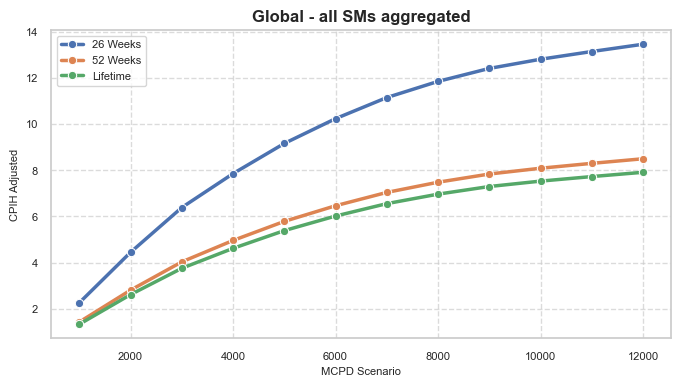

In [ ]:
# Global - all SMs aggregated
submarket_id = 0

df_cpih_wad_26w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[0]
df_cpih_wad_52w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[1]

plot_mcpd_and_cpih('Global - all SMs aggregated', df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4)

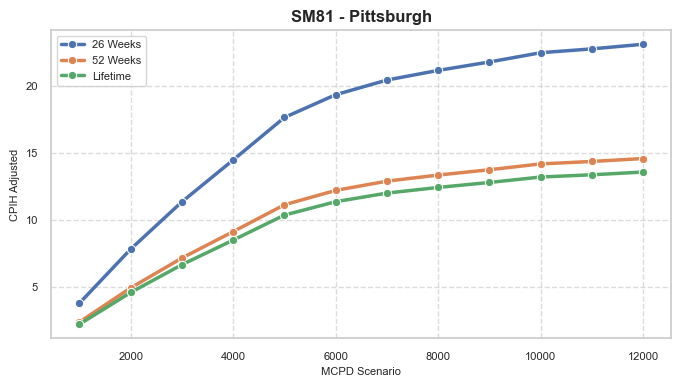

In [594]:
# Pittsburgh
submarket_id = 81

df_cpih_wad_26w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[0]
df_cpih_wad_52w_agg_q4 = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)[1]

plot_mcpd_and_cpih('SM81 - Pittsburgh', df_cpih_wad_26w_agg_q4, df_cpih_wad_52w_agg_q4)

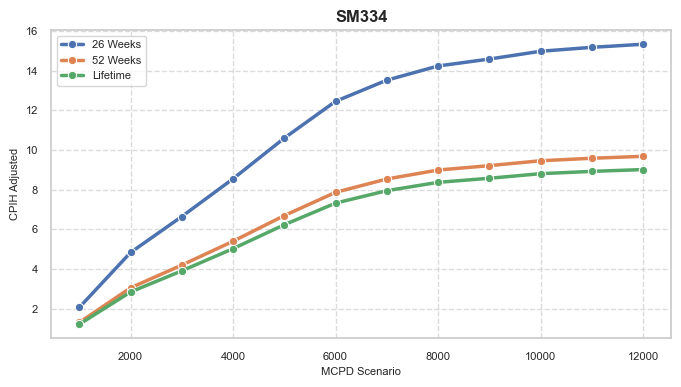

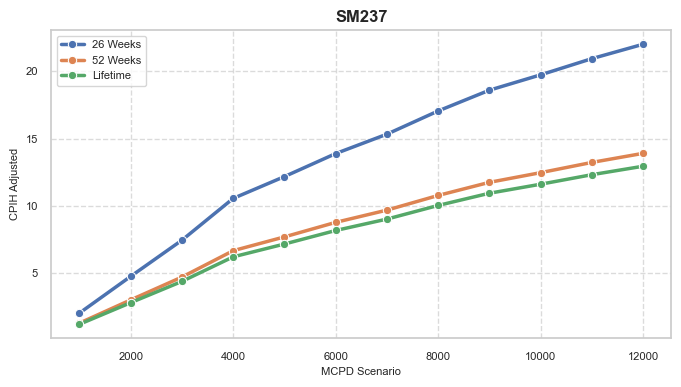

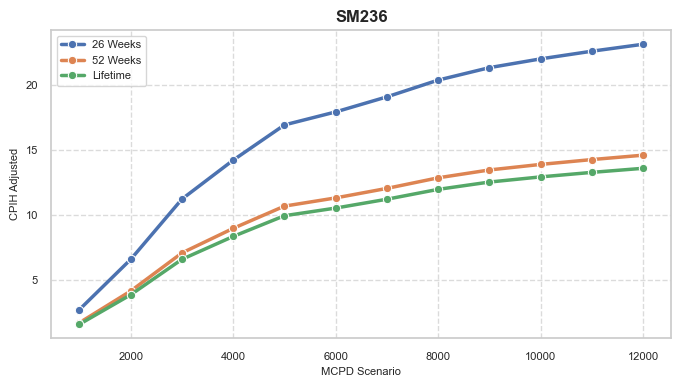

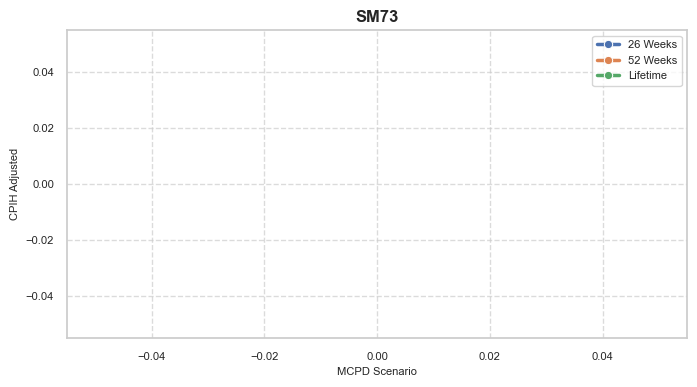

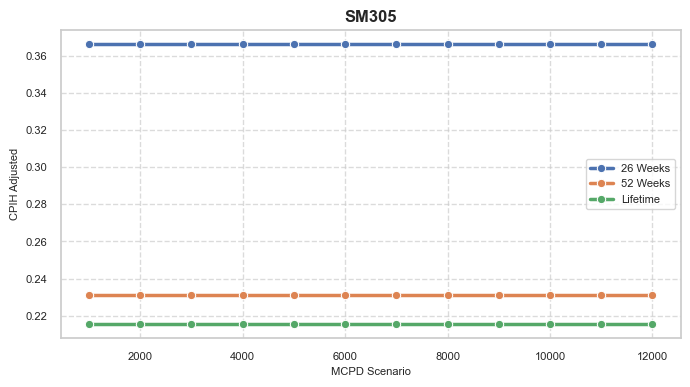

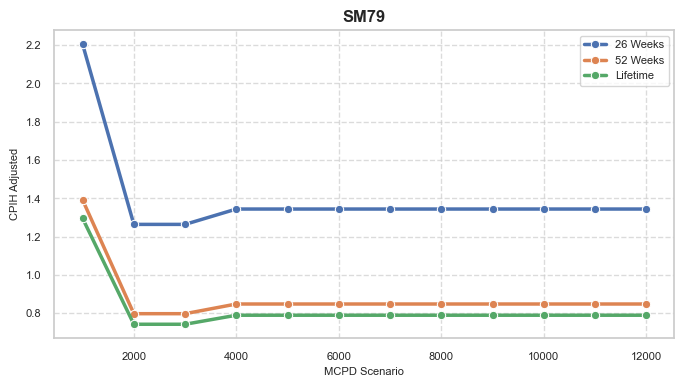

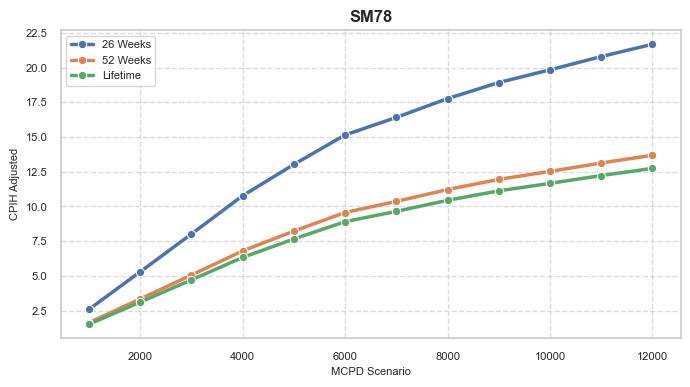

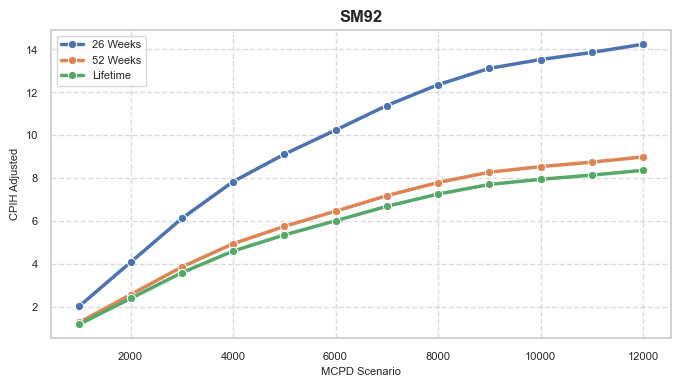

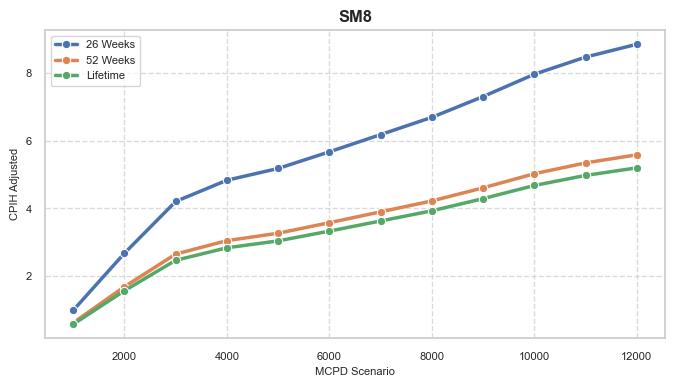

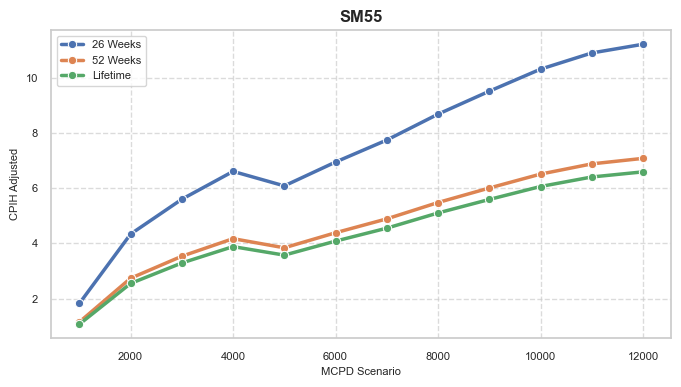

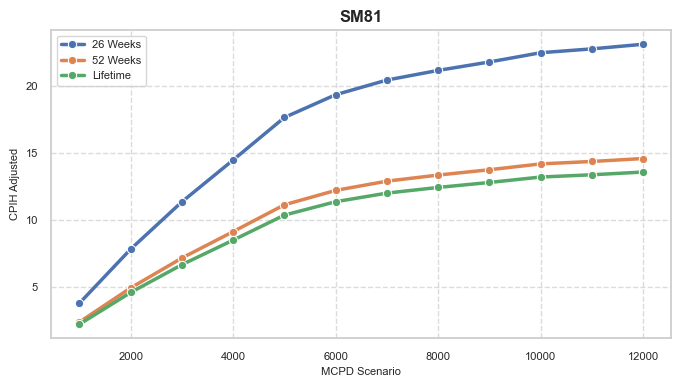

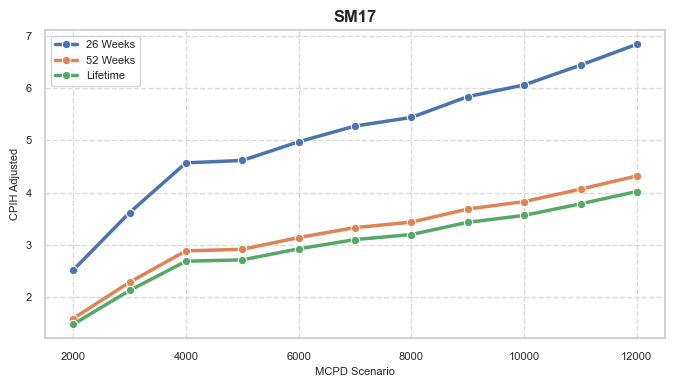

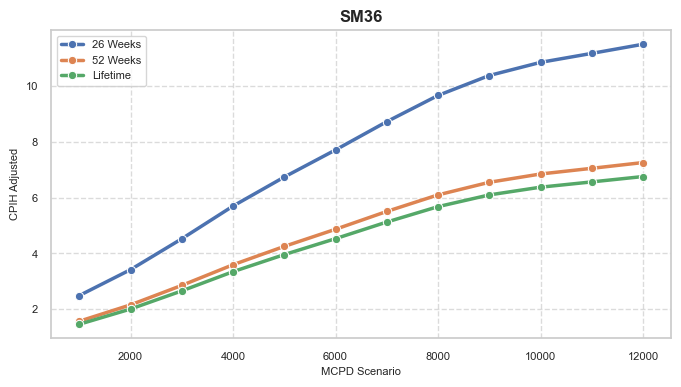

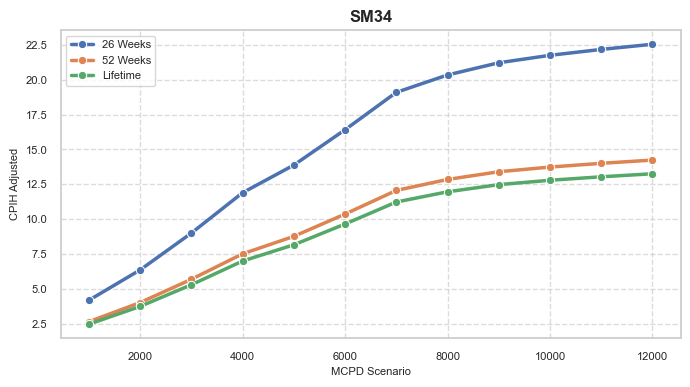

In [596]:

# Initialize empty DataFrames to store aggregated results
df_cpih_wad_26w_agg_q4_pitts_cohort = pd.DataFrame()
df_cpih_wad_52w_agg_q4_pitts_cohort = pd.DataFrame()

# List of submarket IDs
sm_list = [334, 237, 236, 73, 305, 79, 78, 92, 8, 55, 81, 17, 36, 34]

# Loop through each submarket ID
for submarket_id in sm_list:
    # Run analysis for the current submarket ID
    df_26w, df_52w = run_analysis(submarket_id, daco_spend_to_applicants_curve, new_dx_landing_curve, new_dx_retention_curve, global_dx_retention)
    
    # Append the results to the aggregated DataFrames
    df_cpih_wad_26w_agg_q4 = pd.concat([df_cpih_wad_26w_agg_q4, df_26w], ignore_index=True)
    df_cpih_wad_52w_agg_q4 = pd.concat([df_cpih_wad_52w_agg_q4, df_52w], ignore_index=True)
    
    # Plot the results
    plot_mcpd_and_cpih(f'SM{submarket_id}', df_26w, df_52w)